In [2]:
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import json
import os
import re

In [3]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")

In [4]:
# load training data
with open("data/training_set.json", 'r') as f:
    train_datas = json.load(f)

In [1]:

def preprocess(datas, rm_stop_words=False):
    texts = []
    senti_scores = []
    for data in datas:
        
        snippet = data["snippet"]
        
        if type(snippet) == list:
            snippet = ' '.join(snippet)
        
        elif snippet == [] or snippet == "": # some data have empty snippet
            snippet = data["tweet"]
            
        raw_snippet = snippet

        # remove strange token
        snippet = re.sub('https?://[A-Za-z0-9./]+', ' ', snippet)
        snippet = re.sub(u"(?:[^a-zA-Z0-9\+\-\$'#\/])", ' ', snippet)

        snippet = snippet.lower().split(' ')
    
        # monitor if empty
        if snippet == []:
            print raw_snippet
 

        # remove <num>, only leave +<num>, -<num>
        snippet = [re.sub("\d+.*", "<num>", word) for word in snippet]         
        snippet = [re.sub(r'\+<num>.*', '_pos_num', word) for word in snippet]
        snippet = [re.sub(r'\-<num>.*', '_neg_num', word) for word in snippet]
        snippet = [word for word in snippet if "<num>" not in word]
        
        # remove <company>  
        snippet = [word for word in snippet if word.startswith('$') == False]
                
        if rm_stop_words:
            snippet = [word for word in snippet if word not in stopwords.words('english')] # remove stopwords
        
        snippet = [stemmer.stem(word) for word in snippet] # stem words
        snippet = [word for word in snippet if word != '' ]
    
#         print raw_snippet
#         print snippet
        
#         print ' '.join(snippet)
        
#         print snippet
#         print raw_snippet
    
        if snippet == []:
            print "->" + raw_snippet
  
        # ignore empty training data
        if snippet != []:
            texts.append(snippet)
            senti_scores.append(data["sentiment"])
        
    return texts, senti_scores

In [16]:
print "before preprocesing, len(texts): %d" % len(train_datas)

before preprocesing, len(texts): 1396


In [12]:
train_texts, senti_scores = preprocess(train_datas)

->$YOKU 0
->15%


In [13]:
print "after preprocesing, len(texts): %d" % len(train_texts)

after preprocesing, len(texts): 1394


In [484]:
def buildVocab(texts, word_count_threshold=2):
    # borrowed this function from NeuralTalk
    print 'preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, )

    word_counts = {}

    for text in texts:
        for w in text:
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    print "after filter, vocab count: %d"% len(vocab)

    return vocab


In [485]:
def mapWordAndIdx(vocab):

	idx2word = {}
	idx2word[0] = '<pad>'
	idx2word[1] = '<bos>'
	idx2word[2] = '<eos>'
	idx2word[3] = '<unk>'

	word2idx = {}
	word2idx['<pad>'] = 0
	word2idx['<bos>'] = 1
	word2idx['<eos>'] = 2
	word2idx['<unk>'] = 3

	for idx, w in enumerate(vocab):
		word2idx[w] = idx + 4
		idx2word[idx+4] = w

	return word2idx, idx2word

In [486]:
vocab = buildVocab(texts)

preprocessing word counts and creating vocab based on word count threshold 2
after filter, vocab count: 895


In [487]:
word2idx, idx2word = mapWordAndIdx(vocab)

In [488]:
senti_ary = []
for word in word2idx:
    try:
        senti_ary.append( fin_model[word]["market_sentiment"])
    except:
        senti_ary.append(0.0)

senti_ary = np.array(senti_ary)

np.save('data/senti_ary', senti_ary)
senti_ary.shape
len(word2idx)

899

In [489]:
x_train = []
bos_idx = word2idx['<bos>']
eos_idx = word2idx['<eos>']
unk_idx = word2idx['<unk>']

for text in texts:
    #     x = [word2idx[word] if word in word2idx else unk_idx for word in text]
    x = [word2idx[word] for word in text if word in word2idx]
#     x = [bos_idx] + x + [eos_idx]
    x_train.append(x)

y_train = senti_scores

In [490]:
x_train = np.array(x_train)
y_train = np.array(y_train)

np.save("data/x_train", x_train)
np.save("data/y_train", y_train)

with open("data/word2idx.json", 'w') as f:
    json.dump(word2idx, f)

with open("data/idx2word.json", 'w') as f:
    json.dump(idx2word, f)

In [491]:
# test data

In [7]:
with open("data/test_set.json", 'r') as f:
    test_datas = json.load(f)

In [17]:
print "before preprocesing, len(texts): %d" % len(test_datas)

before preprocesing, len(texts): 634


In [18]:
test_texts, test_senti_scores = preprocess(test_datas)

In [20]:
print "after preprocesing, len(texts): %d" % len(test_texts)

after preprocesing, len(texts): 634


In [495]:
x_test = []
bos_idx = word2idx['<bos>']
eos_idx = word2idx['<eos>']
unk_idx = word2idx['<unk>']

for text in test_texts:
#     x = [word2idx[word] if word in word2idx else unk_idx for word in text]
    x = [word2idx[word] for word in text if word in word2idx]
#     x = [bos_idx] + x + [eos_idx]
    x_test.append(x)

y_test = test_senti_scores

In [497]:
x_test = np.array(x_test)
y_test = np.array(y_test)

np.save("data/x_test", x_test)
np.save("data/y_test", y_test)

## experiment 1: Bag of words (CountVectorizer)
想了解 n_gram 對於 model 的影響，並了解取多少 features (500-5500) 是最恰當的
- n_gram = (1, 1): vocabulary 只包含 unigram
- n_gram = (1, 2): vocabulary 包含 unigram, bigram
- n_gram = (1, 3): vocabulary 包含 unigram, bigram, trigram

In [33]:
# predict
from sklearn.feature_extraction.text import CountVectorizer
from mlp import predict
cnt_mse_scores = []
ngram_ranges = [(1, 1), (1, 2), (1, 3)]

for ngram_range in ngram_ranges:
    scores = []
    for max_features in range(500, 5500, 200):

        vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    
        try:
            corpus = [' '.join(text) for text in train_texts]
            x_train = vectorizer.fit_transform(corpus)
            x_train = x_train.toarray()

            corpus = [' '.join(text) for text in test_texts]
            x_test = vectorizer.transform(corpus)
            x_test = x_test.toarray()

            np.save("data/x_train", x_train)
            np.save("data/x_test", x_test)

            score = predict(max_features)
            scores.append( score )
    
        except:  
            print "max_feature is larger than total ngram!"
            scores.append( None )
            pass

    cnt_mse_scores.append(scores)

x_train shape: (1394, 500)
x_test shape: (634, 500)
Train on 1254 samples, validate on 140 samples
Epoch 1/100
1254/1254 [==============================] - 2s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1050 - val_mean_squared_error: 0.1050
Epoch 2/100
1254/1254 [==============================] - 0s - loss: 0.0782 - mean_squared_error: 0.0782 - val_loss: 0.0866 - val_mean_squared_error: 0.0866
Epoch 3/100
1254/1254 [==============================] - 0s - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0886 - val_mean_squared_error: 0.0886
Epoch 4/100
1254/1254 [==============================] - 0s - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0846 - val_mean_squared_error: 0.0846
Epoch 5/100
1254/1254 [==============================] - 0s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0808 - val_mean_squared_error: 0.0808
Epoch 6/100
1254/1254 [==============================] - 0s - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.086

1254/1254 [==============================] - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0909 - val_mean_squared_error: 0.0909
Epoch 7/100
1254/1254 [==============================] - 0s - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0912 - val_mean_squared_error: 0.0912
Epoch 8/100
1254/1254 [==============================] - 0s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 9/100
1254/1254 [==============================] - 0s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0887 - val_mean_squared_error: 0.0887
Epoch 10/100
1254/1254 [==============================] - 0s - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0878 - val_mean_squared_error: 0.0878
Epoch 11/100
1254/1254 [==============================] - 0s - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0863 - val_mean_squared_error: 0.0863
Epoch 12/100
1254/1254 [==============================] - 0s - loss: 0.015

1254/1254 [==============================] - 0s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0894 - val_mean_squared_error: 0.0894
Epoch 16/100
1254/1254 [==============================] - 0s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0840 - val_mean_squared_error: 0.0840
score: 0.070
x_train shape: (1394, 2700)
x_test shape: (634, 2700)
Train on 1254 samples, validate on 140 samples
Epoch 1/100
1254/1254 [==============================] - 2s - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.1058 - val_mean_squared_error: 0.1058
Epoch 2/100
1254/1254 [==============================] - 0s - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0941 - val_mean_squared_error: 0.0941
Epoch 3/100
1254/1254 [==============================] - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0930 - val_mean_squared_error: 0.0930
Epoch 4/100
1254/1254 [==============================] - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0

1254/1254 [==============================] - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 6/100
1254/1254 [==============================] - 0s - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0838 - val_mean_squared_error: 0.0838
Epoch 7/100
1254/1254 [==============================] - 0s - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0878 - val_mean_squared_error: 0.0878
Epoch 8/100
1254/1254 [==============================] - 0s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0851 - val_mean_squared_error: 0.0851
Epoch 9/100
1254/1254 [==============================] - 0s - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0874 - val_mean_squared_error: 0.0874
Epoch 10/100
1254/1254 [==============================] - 0s - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0862 - val_mean_squared_error: 0.0862
Epoch 11/100
1254/1254 [==============================] - 0s - loss: 0.0132

1254/1254 [==============================] - 0s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0869 - val_mean_squared_error: 0.0869
Epoch 13/100
1254/1254 [==============================] - 0s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0896 - val_mean_squared_error: 0.0896
Epoch 14/100
1254/1254 [==============================] - 0s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0878 - val_mean_squared_error: 0.0878
Epoch 15/100
1254/1254 [==============================] - 0s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0894 - val_mean_squared_error: 0.0894
Epoch 16/100
1254/1254 [==============================] - 0s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0885 - val_mean_squared_error: 0.0885
score: 0.067
x_train shape: (1394, 500)
x_test shape: (634, 500)
Train on 1254 samples, validate on 140 samples
Epoch 1/100
1254/1254 [==============================] - 2s - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 

1254/1254 [==============================] - 0s - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0772 - val_mean_squared_error: 0.0772
Epoch 5/100
1254/1254 [==============================] - 0s - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0810 - val_mean_squared_error: 0.0810
Epoch 6/100
1254/1254 [==============================] - 0s - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0741 - val_mean_squared_error: 0.0741
Epoch 7/100
1254/1254 [==============================] - 0s - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Epoch 8/100
1254/1254 [==============================] - 0s - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0838 - val_mean_squared_error: 0.0838
Epoch 9/100
1254/1254 [==============================] - 0s - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0827 - val_mean_squared_error: 0.0827
Epoch 10/100
1254/1254 [==============================] - 0s - loss: 0.0150 

1254/1254 [==============================] - 2s - loss: 0.1359 - mean_squared_error: 0.1359 - val_loss: 0.1117 - val_mean_squared_error: 0.1117
Epoch 2/100
1254/1254 [==============================] - 0s - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0882 - val_mean_squared_error: 0.0882
Epoch 3/100
1254/1254 [==============================] - 0s - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0837 - val_mean_squared_error: 0.0837
Epoch 4/100
1254/1254 [==============================] - 0s - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0858 - val_mean_squared_error: 0.0858
Epoch 5/100
1254/1254 [==============================] - 0s - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0833 - val_mean_squared_error: 0.0833
Epoch 6/100
1254/1254 [==============================] - 0s - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0853 - val_mean_squared_error: 0.0853
Epoch 7/100
1254/1254 [==============================] - 0s - loss: 0.0167 -

1254/1254 [==============================] - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 16/100
1254/1254 [==============================] - 0s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0785 - val_mean_squared_error: 0.0785
Epoch 17/100
1254/1254 [==============================] - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0812 - val_mean_squared_error: 0.0812
Epoch 18/100
1254/1254 [==============================] - 0s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0808 - val_mean_squared_error: 0.0808
Epoch 19/100
1254/1254 [==============================] - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0830 - val_mean_squared_error: 0.0830
Epoch 20/100
1254/1254 [==============================] - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0783 - val_mean_squared_error: 0.0783
Epoch 21/100
1254/1254 [==============================] - 0s - loss: 0.

### 畫成圖看看
n_gram = (1,1) 全部 vocabulary 只有 1516 ，所以線被截斷
#### finding:
- bigram, trigram 在 feature size 較大時(3000~5000)，模型效能較佳
- trigram 在 feature size 較大時比 bigram 稍微好一些
- 最好的 score 出現在 bigram, features_size=3200

<module 'matplotlib.pyplot' from '/4t/jackyyeh/NLP_project1/.env/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

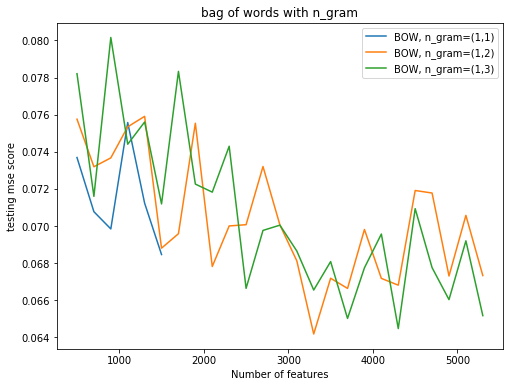

In [34]:
import matplotlib.pyplot as plt
from IPython.display import display

x = range(500, 5500, 200)

plt.figure(figsize=(8,6))
plt.plot(x, cnt_mse_scores[0], label='BOW, n_gram=(1,1)')
plt.plot(x, cnt_mse_scores[1], label='BOW, n_gram=(1,2)')
plt.plot(x, cnt_mse_scores[2], label='BOW, n_gram=(1,3)')
plt.title("bag of words with n_gram")
plt.xlabel("Number of features")
plt.ylabel("testing mse score")
plt.legend()

display(plt)

## experiment 2 : Bag of words with "tfidf weight"(TfidfVectorizer)
想了解 tfidf weight 對於 model 的影響，跟前一個 bag of words model 比較

In [18]:
# predict
from sklearn.feature_extraction.text import TfidfVectorizer
from mlp import predict
tfidf_mse_scores = []
ngram_ranges = [(1, 1), (1, 2), (1, 3)]

for ngram_range in ngram_ranges:
    scores = []
    for max_features in range(500, 5500, 200):

        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    
        try:
            corpus = [' '.join(text) for text in train_texts]
            x_train = vectorizer.fit_transform(corpus)
            x_train = x_train.toarray()

            corpus = [' '.join(text) for text in test_texts]
            x_test = vectorizer.transform(corpus)
            x_test = x_test.toarray()

            np.save("data/x_train", x_train)
            np.save("data/x_test", x_test)

            score = predict(max_features)
            scores.append( score )
    
        except:  
            print "max_feature is larger than total ngram!"
            scores.append( None )
            pass

    tfidf_mse_scores.append(scores)

x_train shape: (1379, 500)
x_test shape: (626, 500)
max_feature is larger than total ngram!
x_train shape: (1379, 700)
x_test shape: (626, 700)
max_feature is larger than total ngram!


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(500,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(700,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


x_train shape: (1379, 900)
x_test shape: (626, 900)
max_feature is larger than total ngram!
x_train shape: (1379, 1100)
x_test shape: (626, 1100)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(900,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(1100,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1300)
x_test shape: (626, 1300)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(1300,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(1500,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(1700,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(1900,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(2100,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(2300,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(2500,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(2700,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(2900,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(3100,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(3300,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(3500,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(3700,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(3900,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(4100,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(4300,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(4500,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(4700,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(4900,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!


mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(5100,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))
mlp.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal", input_shape=(5300,))`
  model.add(Dense(512, init='normal', activation='relu', input_shape=(vocab_size,)))


x_train shape: (1379, 1424)
x_test shape: (626, 1424)
max_feature is larger than total ngram!
x_train shape: (1379, 500)
x_test shape: (626, 500)
max_feature is larger than total ngram!
x_train shape: (1379, 700)
x_test shape: (626, 700)
max_feature is larger than total ngram!
x_train shape: (1379, 900)
x_test shape: (626, 900)
max_feature is larger than total ngram!
x_train shape: (1379, 1100)
x_test shape: (626, 1100)
max_feature is larger than total ngram!
x_train shape: (1379, 1300)
x_test shape: (626, 1300)
max_feature is larger than total ngram!
x_train shape: (1379, 1500)
x_test shape: (626, 1500)
max_feature is larger than total ngram!
x_train shape: (1379, 1700)
x_test shape: (626, 1700)
max_feature is larger than total ngram!
x_train shape: (1379, 1900)
x_test shape: (626, 1900)
max_feature is larger than total ngram!
x_train shape: (1379, 2100)
x_test shape: (626, 2100)
max_feature is larger than total ngram!
x_train shape: (1379, 2300)
x_test shape: (626, 2300)
max_feature 

### 畫個圖看看
加了 tfidf weight 效能明顯變差

<module 'matplotlib.pyplot' from '/4t/jackyyeh/NLP_project1/.env/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

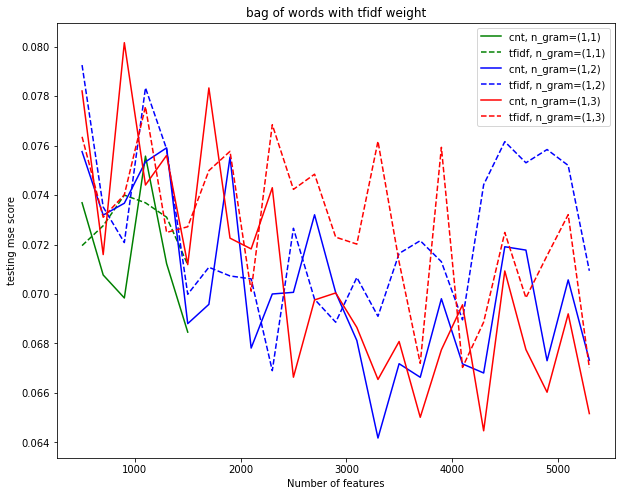

In [37]:
import matplotlib.pyplot as plt
from IPython.display import display

x = range(500, 5500, 200)

plt.figure(figsize=(10,8))
plt.plot(x, cnt_mse_scores[0], label='cnt, n_gram=(1,1)', color='g')
plt.plot(x, tfidf_mse_scores[0], label='tfidf, n_gram=(1,1)', linestyle='--', color='g')
plt.plot(x, cnt_mse_scores[1], label='cnt, n_gram=(1,2)', color='b')
plt.plot(x, tfidf_mse_scores[1], label='tfidf, n_gram=(1,2)', linestyle='--', color='b')
plt.plot(x, cnt_mse_scores[2], label='cnt, n_gram=(1,3)', color='r')
plt.plot(x, tfidf_mse_scores[2], label='tfidf, n_gram=(1,3)', linestyle='--', color='r')
plt.title("bag of words with tfidf weight")
plt.xlabel("Number of features")
plt.ylabel("testing mse score")
plt.legend()

display(plt)

## 小結
根據 experiment1, experiment2，發現 model 用 CountVectorizer, trigram, large feature_size 效果較佳

所以下面的實驗都是以此設定來實作

## experiment 3 : remove stop words
看看 stopwords 是否會影響模型效能

In [20]:
train_texts, y_train = preprocess(train_datas, rm_stop_words = True)
print '-'*10
test_texts, y_test = preprocess(test_datas, rm_stop_words = True)

y_train = np.array(y_train)
y_test = np.array(y_test)

np.save("data/y_train", y_train)
np.save("data/y_test", y_test)

->In
->$FFIV up 7$
->down 5.43 %
->in from 3.61
->$YOKU 0
->up 7$
->$GPRO up
->Out $AAPL
->in the $3s
->15%
->Over 30.37
->out of $FB into $aapl
->up 1%
->$amba down
->in from 3.61
->all out for now
->In 73.24
----------
->up $5.80
->$NFLX at $44B
->$VIAB down 40%
->$MTD $341 from $325 
->is up 19%
->Out $BIDU for now
->out of $KRE
->is up 19%


In [ ]:
# predict
from sklearn.feature_extraction.text import CountVectorizer
from mlp import predict
import tensorflow as tf
mse_scores = []
ngram_ranges = (1, 3)
max_features_range = range(3000, 5000, 200)

for max_features in max_features_range:

    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    
    corpus = [' '.join(text) for text in train_texts]
    x_train = vectorizer.fit_transform(corpus)
    x_train = x_train.toarray()

    corpus = [' '.join(text) for text in test_texts]
    x_test = vectorizer.transform(corpus)
    x_test = x_test.toarray()

    np.save("data/x_train", x_train)
    np.save("data/x_test", x_test)

    score = predict(max_features)
    mse_scores.append(score)

x_train shape: (1379, 3000)
x_test shape: (626, 3000)
Train on 1241 samples, validate on 138 samples
Epoch 1/100


In [54]:
# check
score_sort = np.load('score_sort.npy')
pred = np.load('pred.npy')

sort_idx = score_sort.reshape([-1,]).argsort()
for idx in sort_idx[:20]:
    print "%f <--> %f" % (y_test[idx], pred[idx])
    print test_texts[idx]
    print test_datas[idx]
    print ""

-0.319000 <--> -0.318709
[u'alot', u'to', u'worri', u'about']
{u'snippet': u'alot to worry about', u'tweet': u'@MattKelmon 4 more years will be alot to worry about $spy $dia', u'target': u'$SPY', u'sentiment': -0.319}

-0.389000 <--> -0.389600
[u'anoth', u'sell', u'rate']
{u'snippet': u'Another Sell Rating', u'tweet': u'Isolationism? Another Sell Rating, Sell Ratings On SPY, QQQ, IWM And Several Companies https://t.co/6NKWEcrBA5 $AAPL $AXP $BAC $BLUE $FXE', u'target': u'$AXP', u'sentiment': -0.389}

-0.389000 <--> -0.389600
[u'anoth', u'sell', u'rate']
{u'snippet': u'Another Sell Rating', u'tweet': u'Isolationism? Another Sell Rating, Sell Ratings On SPY, QQQ, IWM And Several Companies https://t.co/6NKWEcrBA5 $AAPL $AXP $BAC $BLUE $FXE', u'target': u'$BAC', u'sentiment': -0.389}

-0.331000 <--> -0.329954
[u'bad', u'govern', u'not', u'confid', u'in', u'core', u'biz']
{u'snippet': [u'Bad governance', u'not confident in core biz'], u'tweet': u'@jay_21_ maybe $YHOO or $BABA. Bad governance

In [55]:

for idx in sort_idx[-20:]:
    print "%f <--> %f" % (y_test[idx], pred[idx])
    print test_texts[idx]
    print test_datas[idx]
    print ""

0.361000 <--> -0.281642
[u'sell', u'short', u'posit', u'on']
{u'snippet': u'Sell Short Position on', u'tweet': u'$CNP Sell Short Position on CNP,...Closed for Profit $ 59,367.00 (7.75%) http://stks.co/ghjc', u'target': u'$CNP', u'sentiment': 0.361}

0.543000 <--> -0.102388
[u'oil', u'back', u'abov']
{u'snippet': u'oil back above 60', u'tweet': u'$WRES moves better w/ oil anyways, oil back above 60', u'target': u'$WRES', u'sentiment': 0.543}

-0.193000 <--> 0.452947
[u'indic', u'are', u'ralli', u'today', u'a', u'lot', u'of', u'the', u'high', u'cover', u'compani', u"'", u'are', u'underperform']
{u'snippet': [u'Indices are rallying today', u"a lot of the 'highly covered companies' are underperforming"], u'tweet': u'Indices are rallying today, but it seems like a lot of the "highly covered companies" are underperforming $AAPL $FB $AMZN $MCD $SPY', u'target': u'$AMZN', u'sentiment': -0.193}

-0.329000 <--> 0.332659
[u'bullshit', u'!', u'all', u'#', u'applestor', u'are', u'empti', u'in', u'#